In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

# NNMF reminder

Matrix factorisation consists in expressing one matrix as the product of two smaller matrices. The idea is to have a lower rank approximation of the original matrix. This lower rank approximation relies on an approximation of the latent factors and thus offers an insight on the problem.

Applications include signal decomposition, where a matrix of signals is decomposed into a set of base components along with a mixing matrix. In recommender systems, considering a matrix of user ratings for movies, matrix factorisation infers the latent characteristics of the movies and the affinity of users for each of them.

Given a matrix $\mathbf{R} \in \mathbb{R}^{n \times m}$, we want to find the matrices $\mathbf{P} \in \mathbb{R}^{n \times k}$ and $\mathbf{Q} \in \mathbb{R}^{m \times k}$ such as
$$\hat{\mathbf{R}} = \mathbf{P} \cdot \mathbf{Q}^\top \approx \mathbf{R}$$


# The gradient descent

The simplest way to compute the matrices $\mathbf{P}$ and $\mathbf{Q}$ is to use a gradient descent. It consists in initializing the estimated matrices randomly, compute their difference to the real data, and follow the gradient of the values to reach a minimum.

We will consider a divergence based on the Euclidean distance: the Frobenius norm:

$$\min_{\mathbf{P}, \mathbf{Q} > 0} \| \mathbf{R} - \mathbf{P} \cdot \mathbf{Q}^\top\|^2_F$$


## The Squared Error

The goal here is to minimize the reconstruction error. The first step is to compute this error. We will write below a function that computes the formula for this error given $\mathbf{R}$, $\mathbf{P}$, $\mathbf{Q}$ and two indices $i$ and $j$:
$$e_{ij} = (r_{ij} - \hat{r}_{ij})^2 = (r_{ij} - \sum_{k}p_{ik} q_{jk})^2$$

In [2]:
def error_at(i, j, R, P, Qt):
    return pow(R[i][j] - np.dot(P[i, :],Qt[:, j]), 2)

## Deriving the update function for $\mathbf{P}$

Now that we have the error, we need to minimize it with regard to $\mathbf{P}$. First, derive the formula above, with regard to $\mathbf{P}$. Then, write, the update function for $\mathbf{P}$. We call $\alpha$ the parameter related to the gradient descent update.
$$\frac{\partial}{\partial p_{ij}}e_{ij} = -2e_{ij}q_{ij}$$
$$p_{t+1} = p_t + 2\alpha e_{ij}q_{ij}$$

In [3]:
def update_P_at(i, j, R, P, Qt, alpha):
    eij = R[i][j] - np.dot(P[i,:], Qt[:,j])
    P[i, :] += alpha * (2 * eij * Qt[:, j])
    # Projection on R+
    np.clip(P, 0, None, out=P)

## Deriving the update function for $\mathbf{Q}$

Do the same for $\mathbf{Q}$. Both matrices being symmetrical in the formulation of the problem, it boils down to replacing swapping $\mathbf{P}$ by $\mathbf{Q}$.
$$\frac{\partial}{\partial q_{ij}}e_{ij} = -2e_{ij}p_{ij}$$
$$q_{t+1} = q_t + 2\alpha e_{ij}p_{ij}$$

In [4]:
def update_Q_at(i, j, R, P, Qt, alpha):
    eij = R[i][j] - np.dot(P[i,:], Qt[:,j])
    Qt[:, j] += alpha * (2 * eij * P[i, :])
    # Projection on R+
    np.clip(Qt, 0, None, out=Qt)

## Iterating

Now that the update functions are coded, all that remains is to iterate and stop at a given criterion. The best is to go for the common methods: having a limited number of steps and a tolerance depending on the value of the error.

In [5]:
def matrix_factorization(R, P, Q, K, steps=5000, alpha=0.0002, es=None):
    Qt = Q.T
    for step in range(steps):
        for i in range(len(R)):
            for j in range(len(R[i])):
                update_P_at(i, j, R, P, Qt, alpha)
                update_Q_at(i, j, R, P, Qt, alpha)
        e = 0
        for i in range(len(R)):
            for j in range(len(R[i])):
                e = e + error_at(i, j, R, P, Qt)
        if es is not None:
            es.append(e)
        if e < 0.001:
            break
    return P, Q

## Simple example

For sanity check, let us tun this algorithm on a toy matrix.

In [6]:
R = [
     [5,3,0,1],
     [4,0,0,1],
     [1,1,0,5],
     [1,0,0,4],
     [0,1,5,4],
    ]
 
R = np.array(R)
 
N = len(R)
M = len(R[0])
K = 2
 
P = np.random.rand(N,K)
Q = np.random.rand(M,K)

es = []
nP, nQ = matrix_factorization(R, P, Q, K, es=es)
nR = np.dot(nP, nQ.T)

print(R)
print(nR)

[[5 3 0 1]
 [4 0 0 1]
 [1 1 0 5]
 [1 0 0 4]
 [0 1 5 4]]
[[5.24955389e+00 1.98875386e+00 2.38747498e-07 1.46840818e+00]
 [3.50267858e+00 1.32696985e+00 2.88535877e-05 9.79823497e-01]
 [1.32739947e+00 9.46037005e-01 1.95419687e+00 3.93073608e+00]
 [9.93971361e-01 7.23825356e-01 1.53133192e+00 3.06724997e+00]
 [5.57398462e-06 6.49596036e-01 2.86449454e+00 5.21748145e+00]]


## Debugging
Debugging machine learning algorithms is most of the time tedious. For this algorithm, we have one guarantee: The global loss should decrease at each iteration. One good reflex is to log this information (if you code a ML API for somebody else, providing that kind of feature will be greatly appreciated). There are two common ways to provide this information. The first one is to add a verbose mode and print the loss. A graph can then be crafted using grep. The second option, in particular for Python, is to provide a list as an option. If the list is present, it will be fed with the value of the loss at each iteration. Implement the latter and display below the plot of the loss.

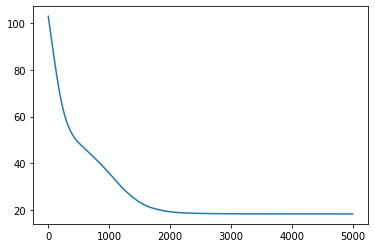

In [7]:
plt.plot(es)

## Comparison with an existing implementation
Scikit-learn is a very famous ML package for Python. They do provide an implementation of the NMF algorithm. Compare your implementation to theirs.

In [8]:
from sklearn.decomposition import NMF


nmf = NMF(n_components=2)
W = nmf.fit_transform(R)
H = nmf.components_
print(np.dot(W, H))

[[5.2558264  1.99313836 0.         1.45512772]
 [3.50429478 1.32891458 0.         0.9701988 ]
 [1.31294288 0.94415991 1.94956896 3.94609389]
 [0.98129195 0.72179987 1.52759811 3.0788454 ]
 [0.         0.65008935 2.84003662 5.21894555]]


# Adding regularization
If you run the script several times, you may notice that the reconstruction is good but the matrices $\mathbf{P}$ and $\mathbf{Q}$ change a lot. A way to fix this problem is to inject more information in the model. It is most of the time done under the the form of a regularization.

The regularization is a term added to the loss that add a constraint on the resulting matrices. The constraint must be adapted to the needs. In the following, we use NMF for the purpose of topic extraction.

In the following, we want to add an L1 and L2 regularizers to the previous algorithm.

A famous application, in particular for L1 norm is the processing of text information. In the following example, we want to extract the topics out of a corpus of documents. The first step is compute the tf-idf measure for each word.

In [9]:
documents = [
    ["Hadoop", "Big Data", "HBase", "Java", "Spark", "Storm", "Cassandra"],
    ["NoSQL", "MongoDB", "Cassandra", "HBase", "Postgres"],
    ["Python", "scikit-learn", "scipy", "numpy", "statsmodels", "pandas"],
    ["R", "Python", "statistics", "regression", "probability"],
    ["machine learning", "regression", "decision trees", "libsvm"],
    ["Python", "R", "Java", "C++", "Haskell", "programming languages"],
    ["statistics", "probability", "mathematics", "theory"],
    ["machine learning", "scikit-learn", "Mahout", "neural networks"],
    ["neural networks", "deep learning", "Big Data", "artificial intelligence"],
    ["Hadoop", "Java", "MapReduce", "Big Data"],
    ["statistics", "R", "statsmodels"],
    ["C++", "deep learning", "artificial intelligence", "probability"],
    ["pandas", "R", "Python"],
    ["databases", "HBase", "Postgres", "MySQL", "MongoDB"],
    ["libsvm", "regression", "support vector machines"]
]

# Get all unique words
words = [words for doc in documents for words in doc]
words = np.unique(words)

# Create a matrix for tfidf values
tfidf = np.zeros((len(documents), len(words)))

# For each term, compute its idf
idfs = []
for word in words:
    count = np.sum([word in doc for doc in documents])
    idfs.append(np.log(len(documents) / count))
    
# Now fill the tfidf matrix
for iw, word, idf in zip(range(len(words)), words, idfs):
    for id, doc in enumerate(documents):
        tfidf[id, iw] = np.sum(np.asarray(doc) == word) / len(doc) * idf
        
R = tfidf

Now that we have a matrix of data, we can use it with our previous algorithm.

In [10]:
N = len(R)
M = len(R[0])
K = 4
 
P = np.random.rand(N,K)
Q = np.random.rand(M,K)

nP, nQ = matrix_factorization(R, P, Q, K)
nR = np.dot(nP, nQ.T)

The $\mathbf{Q}$ matrix contains, for each word, a score indicating its affinity with each topic. A first sanity check for this algorithm is to look at the 5 top words for each topic.

Print them under the following pattern:

Topic 1: Hadoop, C++, Python, R, NoSQL

Topic 2: ...

In [11]:
for i in range(K):
    print("Topic {}".format(i + 1))
    words_per_topics = Q[:, i]
    # Get the most important ones
    important_words = np.argsort(words_per_topics)[::-1][:7]
    print(words[important_words])

Topic 1
['scipy' 'neural networks' 'statsmodels' 'Java' 'Big Data' 'MongoDB'
 'theory']
Topic 2
['deep learning' 'scikit-learn' 'support vector machines' 'C++'
 'probability' 'programming languages' 'artificial intelligence']
Topic 3
['MapReduce' 'machine learning' 'pandas' 'Mahout' 'Java' 'mathematics'
 'Hadoop']
Topic 4
['HBase' 'decision trees' 'theory' 'libsvm' 'mathematics' 'MongoDB' 'C++']


Another interesting graph to look at is the matrix of weights in Q. We expect each line of $\mathbf{Q}^\top$ (or topic) to contain strongly differentiated values to indicate that the topics are well segmented. Is this the case?

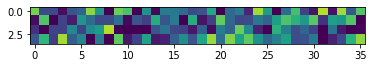

In [12]:
plt.imshow(nQ.T, vmin=0, vmax=1)

## Adding an L2 penalization
Usually, the l2 penalization is applied on both matrices $\mathbf{P}$ and $\mathbf{Q}$. The elements that must be updated are:
* the loss
* the update of $\mathbf{P}$ matrix
* the update of $\mathbf{Q}$ matrix

In [63]:
from numpy.linalg import norm


def error_at(i, j, R, P, Qt, beta):
    return pow(R[i][j] - np.dot(P[i, :],Qt[:, j]), 2)

def update_P_at(i, j, R, P, Qt, alpha, beta):
    eij = R[i][j] - np.dot(P[i,:], Qt[:,j])
    P[i, :] += alpha * (2 * eij * Qt[:, j] - 2 * beta * P[i, :])
    # Projection on R+
    np.clip(P, 0, None, out=P)
        
def update_Q_at(i, j, R, P, Qt, alpha, beta):
    eij = R[i][j] - np.dot(P[i,:], Qt[:,j])
    Qt[:, j] += alpha * (2 * eij * P[i, :] - 2 * beta * Qt[:, j])
    # Projection on R+
    np.clip(Qt, 0, None, out=Qt)
        
        
        
def matrix_factorization(R, P, Q, K, steps=5000, alpha=0.0002, beta=0.02, es=None):
    Qt = Q.T
    for step in range(steps):
        for i in range(len(R)):
            for j in range(len(R[i])):
                update_P_at(i, j, R, P, Qt, alpha, beta)
                update_Q_at(i, j, R, P, Qt, alpha, beta)
        e = 0
        for i in range(len(R)):
            for j in range(len(R[i])):
                e = e + error_at(i, j, R, P, Qt, beta)
        if es is not None:
            es.append(e)
        if e < 0.001:
            break
    return P, Q

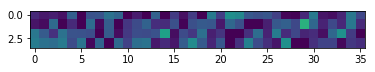

In [64]:
P = np.random.rand(N,K)
Q = np.random.rand(M,K)
es = []
nP, nQ = matrix_factorization(R, P, Q, K, es=es)
nR = np.dot(nP, nQ.T)

# Print topic keywords

plt.imshow(nQ.T, vmin=0, vmax=1)

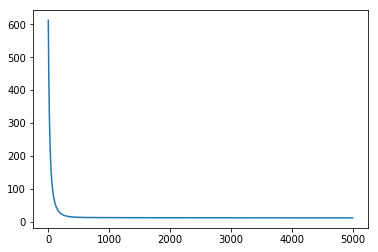

In [65]:
plt.plot(es)

## Adding L1 penalization
Repeat the steps above for the l1 penalization.

In [13]:
from numpy.linalg import norm


def error_at(i, j, R, P, Qt, beta):
    return pow(R[i][j] - np.dot(P[i, :],Qt[:, j]), 2)

def update_P_at(i, j, R, P, Qt, alpha, beta):
    eij = R[i][j] - np.dot(P[i,:], Qt[:,j])
    P[i, :] += alpha * (2 * eij * Qt[:, j] - beta * np.sign(P[i, :]))
    # Projection on R+
    np.clip(P, 0, None, out=P)
        
def update_Q_at(i, j, R, P, Qt, alpha, beta):
    eij = R[i][j] - np.dot(P[i,:], Qt[:,j])
    Qt[:, j] += alpha * (2 * eij * P[i, :] - beta * np.sign(Qt[:, j]))
    # Projection on R+
    np.clip(Qt, 0, None, out=Qt)
        
def matrix_factorization(R, P, Q, K, steps=5000, alpha=0.0002, beta=0.02, es=None):
    Qt = Q.T
    for step in range(steps):
        for i in range(len(R)):
            for j in range(len(R[i])):
                update_P_at(i, j, R, P, Qt, alpha, beta)
                update_Q_at(i, j, R, P, Qt, alpha, beta)
        e = 0
        for i in range(len(R)):
            for j in range(len(R[i])):
                e = e + error_at(i, j, R, P, Qt, beta)
        if es is not None:
            es.append(e)
        if e < 0.001:
            break
    return P, Q

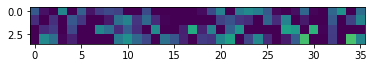

In [14]:
P = np.random.rand(N,K)
Q = np.random.rand(M,K)
es = []
nP, nQ = matrix_factorization(R, P, Q, K, es=es)
nR = np.dot(nP, nQ.T)

# Print topic keywords

plt.imshow(nQ.T, vmin=0, vmax=1)

[[5.79043323e-01 2.02368858e-01 2.92160139e-01 5.20981718e-01
  3.97658926e-01 2.37893791e-01 0.00000000e+00 7.63488200e-02
  1.60266745e-01 2.51245744e-01 2.82338805e-01 0.00000000e+00
  3.46694055e-01 0.00000000e+00 3.41957264e-01 0.00000000e+00
  3.84660728e-01 6.34472851e-02 3.78861708e-01 0.00000000e+00
  0.00000000e+00 4.50534502e-01 0.00000000e+00 2.54753760e-01
  5.58762480e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  2.17608007e-01 2.84648152e-02 4.97925036e-01 3.61378868e-01
  5.97572775e-02 0.00000000e+00 1.96714297e-08 3.05528695e-01]
 [0.00000000e+00 0.00000000e+00 4.01222418e-01 1.13292549e-05
  0.00000000e+00 0.00000000e+00 3.81493743e-01 0.00000000e+00
  2.00334600e-01 6.05849170e-01 3.27954693e-01 3.58023508e-01
  4.63314317e-01 4.18650305e-01 0.00000000e+00 0.00000000e+00
  5.52277112e-02 0.00000000e+00 3.85191355e-01 5.67933138e-02
  3.64029666e-01 8.92629529e-04 0.00000000e+00 0.00000000e+00
  1.21977254e-02 2.69339894e-01 3.46010914e-01 1.63655159e-01
  3.643

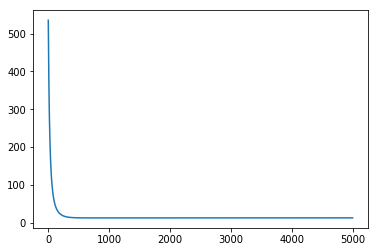

In [62]:
plt.plot(es)

# Recommender systems
The goal of a recommender system is simple: Given a matrix of user/item ratings, infer the rating that would give a user to a given item using the existing ratings.

For once, we are being lucky with this problem in NMF, because the  inference comes for free with most algorithms. It boils down to simply putting 0 in the matrix where the data is missing and *not* performing any optimization on these values.

In [68]:
from numpy.linalg import norm


def error_at(i, j, R, P, Qt):
    return pow(R[i][j] - np.dot(P[i, :],Qt[:, j]), 2)

def update_P_at(i, j, R, P, Qt, alpha):
    eij = R[i][j] - np.dot(P[i,:], Qt[:,j])
    P[i, :] += alpha * (2 * eij * Qt[:, j])
    # Projection on R+
    np.clip(P, 0, None, out=P)
        
def update_Q_at(i, j, R, P, Qt, alpha):
    eij = R[i][j] - np.dot(P[i,:], Qt[:,j])
    Qt[:, j] += alpha * (2 * eij * P[i, :])
    # Projection on R+
    np.clip(Qt, 0, None, out=Qt)
        
        
        
def matrix_factorization(R, P, Q, K, steps=5000, alpha=0.0002, es=None):
    Qt = Q.T
    for step in range(steps):
        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i, j] != 0: # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
                    update_P_at(i, j, R, P, Qt, alpha)
                    update_Q_at(i, j, R, P, Qt, alpha)
        e = 0
        for i in range(len(R)):
            for j in range(len(R[i])):
                e = e + error_at(i, j, R, P, Qt)
        if es is not None:
            es.append(e)
        if e < 0.001:
            break
    return P, Q

The example belows shows a matrix where the inferred ratings should be obvious.

In [70]:
R = [
     [5,5,5,1],
     [4,0,5,1],
     [1,1,0,5],
     [1,0,0,4],
     [0,1,5,4],
    ]
 
R = np.array(R)
 
N = len(R)
M = len(R[0])
K = 2
 
P = np.random.rand(N,K)
Q = np.random.rand(M,K)

nP, nQ = matrix_factorization(R, P, Q, K)
nR = np.dot(nP, nQ.T)

print(R)
print(nR)

[[5 5 5 1]
 [4 0 5 1]
 [1 1 0 5]
 [1 0 0 4]
 [0 1 5 4]]
[[4.8595931  5.02678495 5.14932455 0.91902858]
 [3.97201378 4.08856457 4.79025921 1.39311099]
 [1.000217   0.88548465 5.37321133 4.9513849 ]
 [1.30147378 1.23664998 4.54878935 3.74570563]
 [1.20817965 1.12561626 4.87014667 4.1920051 ]]


## Introducing user and item bias
When dealing with recommender systems, each user may have its own bias. A movie can also be biased byt the communication around it. In this kind of method, a bias is represented as a constant corresponding to each user and each movie.

Modifiy the current system to integrate user and movie bias in your optimization.

In [49]:
import numpy as np
from sklearn.base import BaseEstimator


class Recommender(BaseEstimator):
    
    def __init__(self, k=2, unrated_value=0, n_iter=5000, alpha=0.0002, beta=0.02):
        self.mean_ = None
        self.P_ = None
        self.Q_ = None
        self.P_bias_ = None
        self.Q_bias_ = None
        self._k = k
        self._unrated_value = unrated_value
        self._n_iter = n_iter
        self._alpha = alpha
        self._beta = beta
    
    def fit(self, X, y=None, **fit_params):
        N, M = X.shape
        K = self._k
        self._es = []
        
        alpha = self._alpha
        beta = self._beta
 
        # Take a mask of ratings
        mask = (X != self._unrated_value)
        
        self.mean_ = np.mean(X[mask])

        # Init biases
        P_bias = np.zeros(N)
        Q_bias = np.zeros(M)
        
        # Initialize matrices
        P = np.random.rand(N,K)
        Q = np.random.rand(M,K)
        
        Qt = Q.T
        for iter in range(self._n_iter):
            err = 0
            for i, j in zip(*np.where(mask)):
                
                # Current prediction
                eij = X[i, j] - (self.mean_ + P_bias[i] + Q_bias[j] + np.dot(P[i,:], Qt[:,j]))
                err += eij       

                # Update biases
                P_bias[i] += alpha * (eij - beta * P_bias[i])
                Q_bias[j] += alpha * (eij - beta * Q_bias[j]) 

                # Update of P
                P[i, :] += alpha * (eij * Qt[:, j] - beta * P[i, :])
                    
                # Update of Q
                Qt[:, j] += alpha * (eij * P[i, :] - beta * Qt[:, j])
            self._es.append(err)
        self.P_ = P
        self.Q_ = Qt.T
        self.P_bias_ = P_bias
        self.Q_bias_ = Q_bias
        
    def predict(self, X, **fit_params):
        # X is a list of (user_id, item_id)
        pred = []
        for (user_id, item_id) in X:
            pred.append(self.mean_ + self.P_bias_[user_id] + self.Q_bias_[item_id] + np.dot(self.P_[user_id, :], self.Q_[item_id, :].T))

In [54]:
N, M, K = 100, 20, 10

user_bias = np.array([-0.5, 0.5] * (N // 2))
item_bias = np.array([-0.5, 0.5] * (M // 2))
mean = 3.
P_true = np.random.rand(N,K) - 0.5
Q_true = np.random.rand(M,K) - 0.5

ratings = np.dot(P_true, Q_true.T) + np.repeat(user_bias[:, None], M, axis=1) + np.repeat(item_bias[None, :], N, axis=0) 
ratings += mean

# Generate a mask
ratio = 0.2
mask = np.random.rand(N, M) > (1. - ratio)

X = ratings.copy()
X[mask] = 0.

reco = Recommender(k=K)
reco.fit(X)

Difference between truth and estimation
Mean estimation: truth {0:.2f}, estimated {1:.2f} 3.0 2.9887690945874277


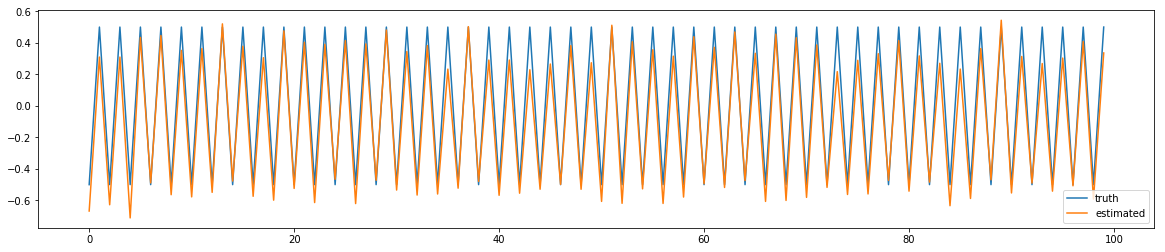

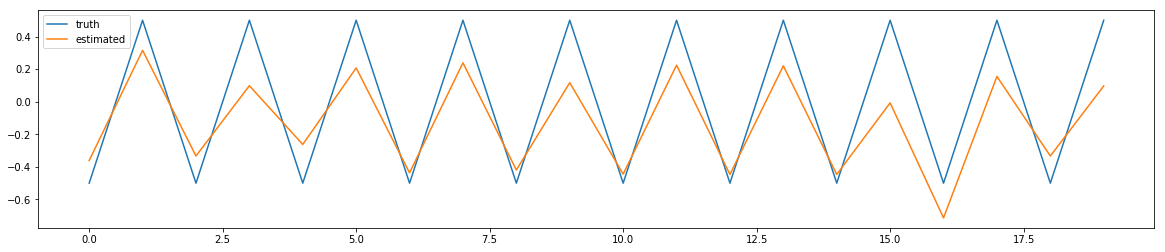

In [67]:
print('Difference between truth and estimation')

print('Mean estimation: truth {0:.2f}, estimated {1:.2f}', mean, reco.mean_)

plt.figure(figsize=(20, 4))
plt.plot(user_bias, label='truth')
plt.plot(reco.P_bias_, label='estimated')
plt.legend()

plt.figure(figsize=(20, 4))
plt.plot(item_bias, label='truth')
plt.plot(reco.Q_bias_, label='estimated')
plt.legend()